# Data Extraction and Detecting Time Series Components

First thing first, let me import the Python libraries first.

In [1]:
import requests
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

For the sake of practice, let me work with telecom industry and to do that I pick `AT&T` (T) and `Verizon` (VZ). As a stock price I choose closing price, which is more stable and informative compared to high, low, open. Adjusted closing price would be an another good choice. 

The period that I cover is 01/01/2020-06/01/2021 and the stock price data is daily, meaning that we have 253 observations. 

Please note that you can also use [pandas datareader](https://pandas-datareader.readthedocs.io/en/latest/) to make use of yahoo finance as well as other APIs to access the stock price

In [2]:
def getDailyData(symbol):
        parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': symbol,
                       'outputsize':'full',
                       'datatype': 'csv', 
                       'apikey': 'LL1WA15IW41XV2T2'}

        response = requests.get('https://www.alphavantage.co/query', params=parameters)

        # Process the CSV file retrieved
        csvText = StringIO(response.text)
        data = pd.read_csv(csvText, index_col='timestamp')
        return data

In [3]:
symbols= ['T', 'VZ']
data=[]
for symbol in symbols:
    data.append(getDailyData(symbol)[::-1]['close']['2019,1,1': '2021,6,1'])
stock_prices=pd.DataFrame(data).T
stock_prices.columns=symbols

In [4]:
stock_prices.to_csv('stock_prices.csv')

In [5]:
stock_prices['timestamp'] = pd.to_datetime(stock_prices.index)
stock_prices.set_index(stock_prices['timestamp'])
del stock_prices['timestamp']

In [6]:
stock_prices.head()

,T,VZ
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38


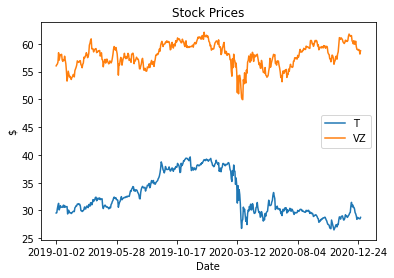

In [7]:
stock_prices.plot()
plt.title('Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

There are some striking observation that I can get from this plot. One of them is the sudden drop occured in the mid of 2020. This corresponds to Covid-19 pandemic and therefore it makes sense to say that pandemic badly affected the stock prices in telecom industry as well as others. The other important observation is that stock price of Verizon exhibits a clear upward movement. However, even though a modest upward trend is visible during pre-Covid-19 era for AT&T, the stock price of this company has not revert back to its previous level.

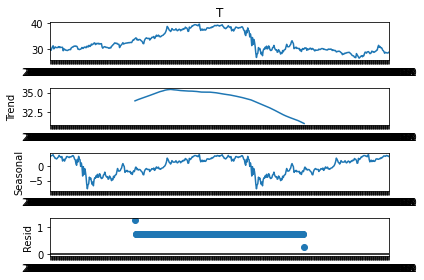

In [5]:
seasonal_decompose(stock_prices['T'], 
                   model = 'additive', 
                   period = int(len(stock_prices)/2)).plot();

Well, now we have three components of the time series. The first plot represents the behavior of raw data and the rest three plots exhibits the trend, seasonality, and residuals.

Let me briefly discuss the additive model with a period of 360. In time series, multiplicative model works well if the amplitude of both the seasonal and irregular variations increase as the level of the trend rises. Alternatively, additive model is suitable when the amplitude of both the seasonal and irregular variations do not change as the level of the trend rises or falls.

In `seasonal_decompose` library, we need to identify the period as long as we do not have timeseries index. Given the period of the data, the parameter period changes. For instance, if the data period is daily, then period becomes 360 and if the data period is monthly, the period takes the value of 12.